In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Let's take a look at the raw data - comprising results for many lifters for many powerlifting meets.

In [2]:
df = pd.read_csv('Data/openpowerlifting.csv')
df.head()

,MeetID,Name,Sex,Equipment,Age,Division,BodyweightKg,WeightClassKg,Squat4Kg,BestSquatKg,Bench4Kg,BestBenchKg,Deadlift4Kg,BestDeadliftKg,TotalKg,Place,Wilks
0,0,Angie Belk Terry,F,Wraps,47.0,Mst 45-49,59.60,60,NaN,47.63,NaN,20.41,NaN,70.31,138.35,1,155.05
1,0,Dawn Bogart,F,Single-ply,42.0,Mst 40-44,58.51,60,NaN,142.88,NaN,95.25,NaN,163.29,401.42,1,456.38
2,0,Dawn Bogart,F,Single-ply,42.0,Open Senior,58.51,60,NaN,142.88,NaN,95.25,NaN,163.29,401.42,1,456.38
3,0,Dawn Bogart,F,Raw,42.0,Open Senior,58.51,60,NaN,NaN,NaN,95.25,NaN,NaN,95.25,1,108.29
4,0,Destiny Dula,F,Raw,18.0,Teen 18-19,63.68,67.5,NaN,NaN,NaN,31.75,NaN,90.72,122.47,1,130.47


In [3]:
df.shape

(377692, 17)

In [4]:
df.isnull().sum()

MeetID                 0
Name                   0
Sex                    0
Equipment              0
Age               235300
Division           15543
BodyweightKg        2363
WeightClassKg       3779
Squat4Kg          376494
BestSquatKg        86237
Bench4Kg          375812
BestBenchKg        29440
Deadlift4Kg       374970
BestDeadliftKg     66891
TotalKg            22801
Place               1090
Wilks              23808
dtype: int64

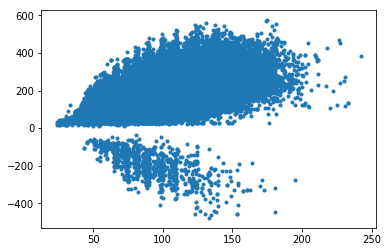

In [5]:
plt.plot(df.BodyweightKg.values, df.BestSquatKg.values, linestyle='None', marker='.')
plt.show()

This is quite a large dataset, with results for 377,692 lifters, however there seem to be a substantial number of negative numbers in columns where these make no sense (bodyweight, weight lifted), and missing values in the age column. Rather than deleting rows with negative values, we'll assume that the magnitude of these numbers are correct, but that they were entered with an erroneous negative sign:

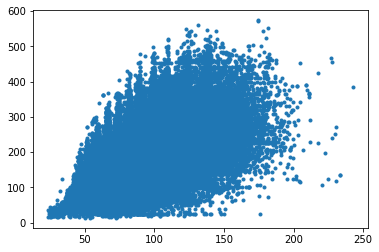

In [6]:
numeric_columns = ['Age', 'BodyweightKg', 'Squat4Kg', 'BestSquatKg', 'Bench4Kg', 'BestBenchKg',
               'Deadlift4Kg', 'BestDeadliftKg', 'TotalKg', 'Wilks']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric)
df[numeric_columns] = df[numeric_columns].abs()
plt.plot(df.BodyweightKg.values, df.BestSquatKg.values, linestyle='None', marker='.')
plt.show()

Seeing as the age and lift4Kg columns contain many null values, let's drop these, then drop all rows with any remaining null values.

In [7]:
keep_cols = ['MeetID', 'Name', 'Sex', 'Equipment', 'BodyweightKg', 'WeightClassKg',
            'BestSquatKg', 'BestBenchKg', 'BestDeadliftKg', 'TotalKg', 'Place', 'Wilks']
df = df[keep_cols]
df = df.dropna()
df.isnull().sum()

MeetID            0
Name              0
Sex               0
Equipment         0
BodyweightKg      0
WeightClassKg     0
BestSquatKg       0
BestBenchKg       0
BestDeadliftKg    0
TotalKg           0
Place             0
Wilks             0
dtype: int64

Let's take a quick look at the relation between bodyweight and weight lifted in each lift. Clearly, we expect that the weight lifted will increase with bodyweight; we'll use the simplest linear regression model and plot these along with the data separately for male and femaile lifters. Additionally, we'll restrict our analysis to only Raw lifters - raw lifting is currently gaining in popularity over equipped and we don't want our analysis to be skewed by including these.

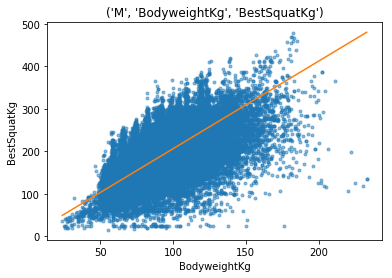

R2 score: 0.2107027071293771



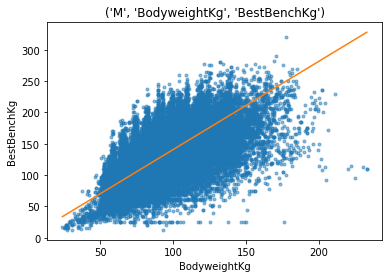

R2 score: 0.25192380429341854



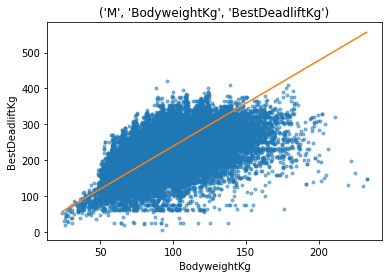

R2 score: -0.08907677402243097



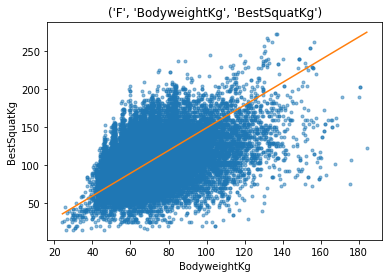

R2 score: -0.08417844643660932



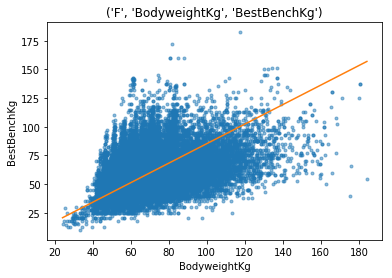

R2 score: -0.1418716919021079



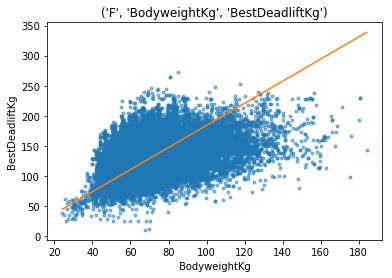

R2 score: -0.39383018068056197



In [8]:
from sklearn.linear_model import LinearRegression

df = df[df.Equipment == 'Raw']

jobs = [('M', 'BodyweightKg', 'BestSquatKg'), ('M', 'BodyweightKg', 'BestBenchKg'), ('M', 'BodyweightKg', 'BestDeadliftKg'), 
('F', 'BodyweightKg', 'BestSquatKg'), ('F', 'BodyweightKg', 'BestBenchKg'), ('F', 'BodyweightKg', 'BestDeadliftKg')]

def plot_lrg(df, job, fit_intercept=True):
    working_df = df[df.Sex == job[0]]
    X = working_df[job[1]].values.reshape(-1, 1)
    y = working_df[job[2]].values.reshape(-1, 1)
    lrg = LinearRegression(fit_intercept=fit_intercept)
    lrg.fit(X, y)
    plt.plot(X, y, linestyle='None', marker='.', alpha=0.5)
    X_model = [min(X), max(X)]
    y_model = lrg.predict(X_model)
    plt.plot(X_model, y_model)
    plt.xlabel(job[1])
    plt.ylabel(job[2])
    plt.title(job)
    plt.show()
    print('R2 score: {}'.format(lrg.score(X, y)))
    print()

for job in jobs:
    plot_lrg(df, job, fit_intercept=False)

Now we can get to what we're really interested in here: the Wilks scores. First off let's look at the relation between bodyweight and Wilks for men and women - given that Wilks is supposed to normalize between weight classes we expect there to be no or only a very weak relation between the two, and this is indeed what we see.

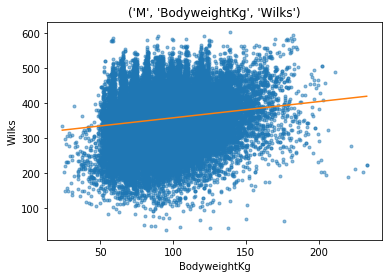

R2 score: 0.021016671331268277



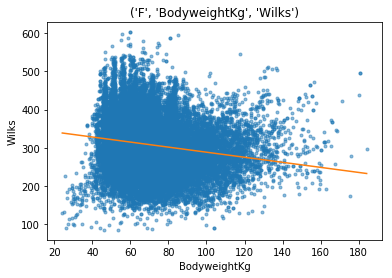

R2 score: 0.028995031169869012



In [9]:
plot_lrg(df, ('M', 'BodyweightKg', 'Wilks'))
plot_lrg(df, ('F', 'BodyweightKg', 'Wilks'))

Plotting this relation for men and women on the same chart, we see lower weights for the women (as expected), and possibly lower Wilks scores - but this merits a much deeper investigation.

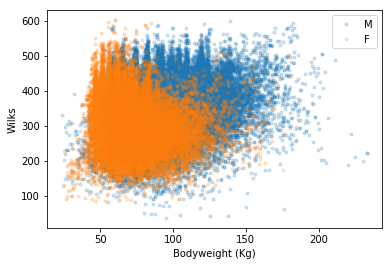

In [10]:
plt.plot(df[df.Sex=='M'].BodyweightKg, df[df.Sex=='M'].Wilks, linestyle='None', marker='.', alpha=0.2, label='M')
plt.plot(df[df.Sex=='F'].BodyweightKg, df[df.Sex=='F'].Wilks, linestyle='None', marker='.', alpha=0.2, label='F')
plt.xlabel('Bodyweight (Kg)')
plt.ylabel('Wilks')
plt.legend()
plt.show()

Let's use seaborn to create some plots to look at the distribution of Wilks scores for men and women:

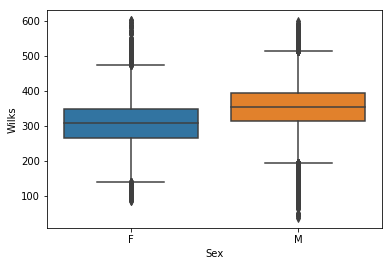

In [11]:
import seaborn as sns

sns.boxplot(x='Sex', y='Wilks', data=df)
plt.show()

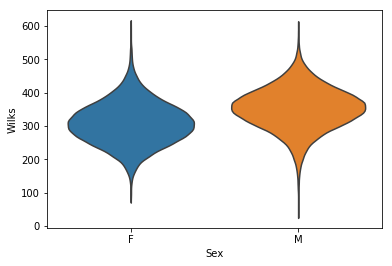

In [12]:
sns.violinplot(x='Sex', y='Wilks', data=df, inner=None)
plt.show()

It looks like that the distribution of Wilks score for women has a slightly lower mean, and higher variance than that for the mens. This sample size is quite large, and if Wilks were a good way of normalizing scores between men and women we may expect to see that the distributions would be roughly the same. However, there are possible selection biases in powerlifting, i.e. the population of male powerlifters has on average better potential than the population of female powerlifters as powerlifting is in general more popular amongst men than women, and so more men with athletic/strength ability may go into powerlifting than women, meaning that Wilks distribution between men and women are not the same but Wilks is still a fair way to compare between the two.

To investigate this further, let's first define Wilks as a function and a) check that the Wilks scores in this datasets are correct and b) look at the form of the coefficient for men and women:

In [13]:
def calc_wilks(weight, sex):
    if sex == 'M':
        a=-216.0475144
        b=16.2606339
        c=-0.002388645
        d=-0.00113732
        e=7.01863E-06
        f=-1.291E-08
    elif sex == 'F':
        a=594.31747775582
        b=-27.23842536447
        c=0.82112226871
        d=-0.00930733913
        e=4.731582E-05
        f=-9.054E-08
    else:
        print('WARNING: pass "M" or "F" as sex to get valid Wilks. Returning None.')
        return None
    return 500/(a + b*weight + c*weight**2 + d*weight**3 + e*weight**4 + f*weight**5)

Calculating Wilks using this definition for all rows in our reduced dataset, we see (thankfully) that the Wilks in the dataset is correct based on the bodyweight and weight lifted per lifter:

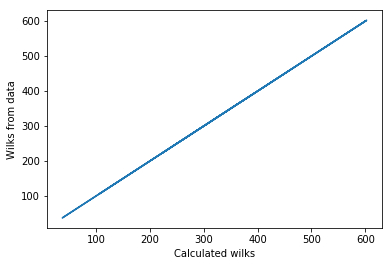

In [14]:
wilks_list = []

for row in df.itertuples():
    wilks_list.append(row.TotalKg * calc_wilks(row.BodyweightKg, row.Sex))
    
plt.plot(wilks_list, df.Wilks.values)
plt.xlabel('Calculated wilks')
plt.ylabel('Wilks from data')
plt.show()

Let's now look at the graph of Wilks coefficient vs weight for men and women to see the differencesL

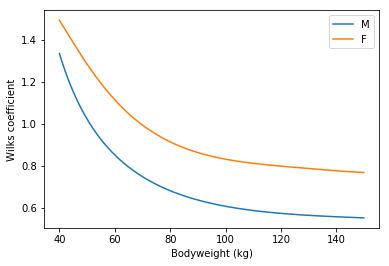

In [15]:
weight = np.arange(40, 150, 0.1)
m_wilks, f_wilks = [], []

for i in weight:
    m_wilks.append(calc_wilks(i, 'M'))
    f_wilks.append(calc_wilks(i, 'F'))

plt.plot(weight, m_wilks, label='M')
plt.plot(weight, f_wilks, label='F')
plt.legend(loc='upper right')
plt.xlabel('Bodyweight (kg)')
plt.ylabel('Wilks coefficient')

plt.show()

Both curves show a similar shape, with the women's coefficient higher than the men's at any given weight, as expected. However, we can see that the women's curve is not the same as the mens but shifted, the gradients are different at each weight point. We can see this difference even more clearly if we look at Wilks over a wider, unrealistic range of bodyweights (where the formula breaks down) - the curves display very different behaviour outside the limit of acceptable bodyweights:

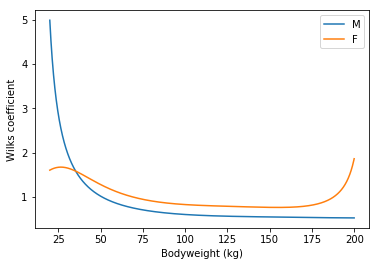

In [16]:
weight = np.arange(20, 200, 0.1)
m_wilks, f_wilks = [], []

for i in weight:
    m_wilks.append(calc_wilks(i, 'M'))
    f_wilks.append(calc_wilks(i, 'F'))

plt.plot(weight, m_wilks, label='M')
plt.plot(weight, f_wilks, label='F')
plt.legend(loc='upper right')
plt.xlabel('Bodyweight (kg)')
plt.ylabel('Wilks coefficient')

plt.show()

More for interest's sake than as an appropriate diagnostic tool to this task, let's look at the distribution of data for all lifters, when looking at sex, weight, total lifted and wilks. We'll do this by TSNE - a dimensionality reduction technique.

In [17]:
# cluster here, pca
# what to cluster on: sex, age, agecat, bw, weightcat, total, wilks

cluster_cols = ['Sex', 'BodyweightKg', 'TotalKg', 'Wilks']
cluster_array = pd.get_dummies(df[cluster_cols]).values
num_samples = 3000
cluster_array = cluster_array[:num_samples, :]
sex = df.Sex.iloc[:num_samples].map(lambda x: 1 if x=='M' else 2).values

In [18]:
# Import TSNE
from sklearn.manifold import TSNE

# Create a TSNE instance: model
model = TSNE(learning_rate=30)

# Apply fit_transform to samples: tsne_features
tsne_features = model.fit_transform(cluster_array)

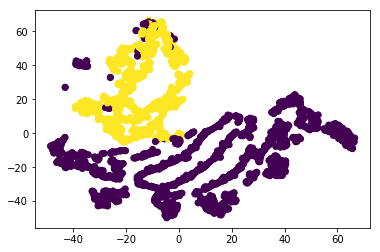

In [19]:
# Select the 0th feature: xs
xs = tsne_features[:,0]

# Select the 1st feature: ys
ys = tsne_features[:,1]
# Scatter plot, coloring by variety_numbers


plt.scatter(xs, ys, c=sex)
plt.show()

The male and female lifters come out in very different places on the TSNE map. This doesn't really tell us a lot, as we used sex as an input into TSNE, and as TSNE can give different looking results with different interations and learning rates. Still, it is interesting to note that the division between male and female lifters in the map is so clear.

One factor we haven't considered yet is the possibility that Wilks is an appropriate normalizing score between "good" lifters, but not so much for less trained or more casual powerlifters. To investigate this, we can reduce the data further so we're only looking at lifters who came top of their respective division in any meet:

In [20]:
winners = df[df.Place == '1']

print('No. male winners: {}'.format(winners[winners.Sex == 'M'].shape[0]))
print('No. distinct male winners: {}'.format(len(winners[winners.Sex == 'M'].Name.unique())))
print('No. female winners: {}'.format(winners[winners.Sex == 'F'].shape[0]))
print('No. distinct female winners: {}'.format(len(winners[winners.Sex == 'F'].Name.unique())))

No. male winners: 39686
No. distinct male winners: 23140
No. female winners: 23829
No. distinct female winners: 13180


The above numbers contain duplicates of lifters, as particularly good lifters may win many competitions. Additionally, we haven't accounted for the possibility for lifters to move between weight classes. To do this, we'll look at the best score achieved per individual lifter, per wight class they competed in - lifters quite often move between weight classes, and their best score will often be in the heaviest weight class they competed in, so we'll treat a given lifter in two separate wight classes as two separate lifters.

In [21]:
winners = winners.groupby(['Name', 'WeightClassKg']).max()

In [22]:
print('No. male winners: {}'.format(winners[winners.Sex == 'M'].shape[0]))
print('No. female winners: {}'.format(winners[winners.Sex == 'F'].shape[0]))

No. male winners: 27433
No. female winners: 15605


Now let's re-examine the distribution of data:

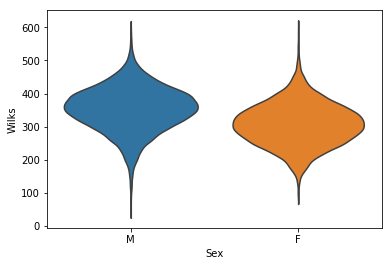

In [23]:
# cluster, pca, ecdf,
sns.violinplot(x='Sex', y='Wilks', data=winners, inner=None)
plt.show()

So even looking at winning lifters, and the best scores per lifter (so avoiding errenous weighting by prolific lifters), we still see a higher mean wilks and tighter variance for men than women.

Let's now define a function for the emperical cumulative distribution, as another way to look at the data:

In [24]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y

Equipped with this function, we'll now take a more detailed look again at the distributions of Wilks for male and female lifters. First, let's look at the histograms, and kernel estimated probability density functions of male and female Wilks scores from the more complete datasets, using Seaborn:

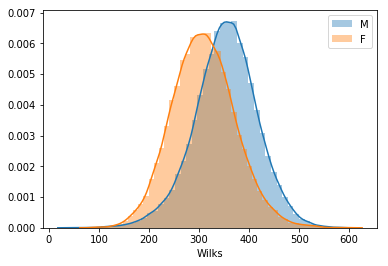

In [25]:
sns.distplot(df[df.Sex == 'M'].Wilks, label = 'M')
sns.distplot(df[df.Sex == 'F'].Wilks, label='F')
plt.legend()
plt.show()

Looking at the emperical cumulative distribution functions for the complete datasets, and the datasets of unique winners only,we see a clear difference between men and women:

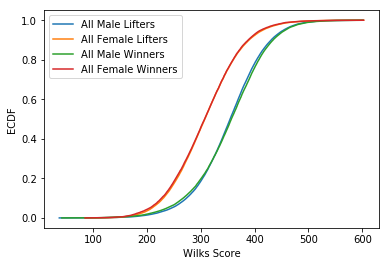

In [26]:
X_m, y_m = ecdf(df[df.Sex == 'M'].Wilks)
X_f, y_f = ecdf(df[df.Sex == 'F'].Wilks)
X_m_win, y_m_win = ecdf(winners[winners.Sex == 'M'].Wilks)
X_f_win, y_f_win = ecdf(winners[winners.Sex == 'F'].Wilks)

plt.plot(X_m, y_m, label='All Male Lifters')
plt.plot(X_f, y_f, label='All Female Lifters')

plt.plot(X_m_win, y_m_win, label='All Male Winners')
plt.plot(X_f_win, y_f_win, label='All Female Winners')

plt.xlabel('Wilks Score')
plt.ylabel('ECDF')
plt.legend(loc='upper left')
plt.show()

It could be argued that our previous way of looking at the top lifters was not a good one - there are many weight and age divisions for a given meet, and for some sparsely occupied divisions lifters that are not as good can still win the division due to lack of competition. If true, then the argument that Wilks normalises well for top competitors may still hold. We can look again at this by more explicitly looking at the top Wilks scores per lifter per weight class:

In [27]:
sorted_men = df[df.Sex == 'M'].groupby(['Name', 'WeightClassKg']).max().sort_values('Wilks', ascending=False)
sorted_women = df[df.Sex == 'F'].groupby(['Name', 'WeightClassKg']).max().sort_values('Wilks', ascending=False)

In [28]:
print('Total men: {}'.format(sorted_men.shape[0]), 'Total women: {}'.format(sorted_women.shape[0]))

Total men: 50370 Total women: 24446


Let's define a function to plot histograms, estimated probability distributions, and cumulative distributions for the top N men and women, then look at these as we vary N:

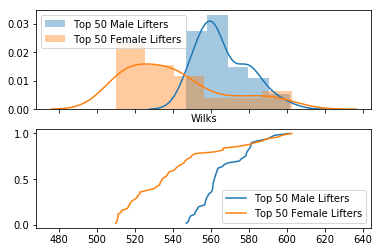

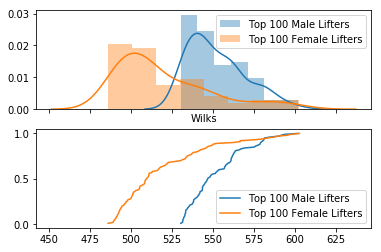

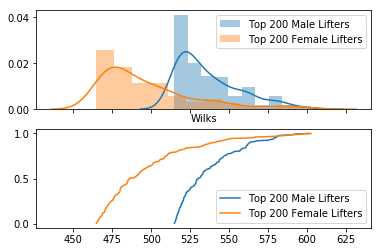

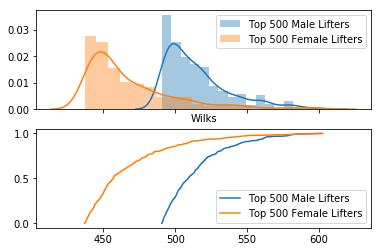

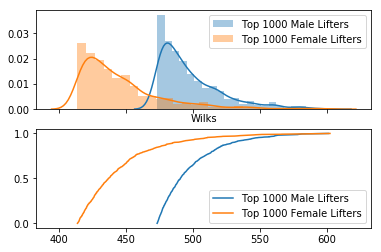

In [29]:
def plot_top_lifters(n, men_df, women_df):
    plt.close('all')
    
    f, axarr = plt.subplots(2, sharex=True)
    
    sns.distplot(men_df.iloc[:n].Wilks, label = 'Top {} Male Lifters'.format(n), ax=axarr[0])
    sns.distplot(women_df.iloc[:n].Wilks, label = 'Top {} Female Lifters'.format(n), ax=axarr[0])
    axarr[0].legend()
    
    X_m_top, y_m_top = ecdf(men_df.iloc[:n].Wilks)
    X_f_top, y_f_top = ecdf(women_df.iloc[:n].Wilks)

    axarr[1].plot(X_m_top, y_m_top, label='Top {} Male Lifters'.format(n))
    axarr[1].plot(X_f_top, y_f_top, label='Top {} Female Lifters'.format(n))

    axarr[1].legend()
    plt.show()

num_list = [50, 100, 200, 500, 1000]
    
for n in num_list:
    plot_top_lifters(n, sorted_men, sorted_women)

We can see that at for all values of n>50 (taking n<50 will lead to a sample size that is probably too small), we still see that the distribution of Wilks scores for men has a higher mean than that for women. At the very top (top few lifters in the world of each sex), Wilks score seem to be similar - however this is for a very small number, and in my opinion is not enough to claim that Wilks is a fair normalizer.

Finally, let's put some numbers into this debate: we can define functions to do a bootstrap permutation test to get a p-value for the hypothesis that two distributions are the same:

In [33]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) - np.mean(data_2)

    return diff

def dist_test(wilks1, wilks2, replicates):
    
    # Compute difference of mean Wilks from experiment
    empirical_diff_means = diff_of_means(wilks1, wilks2)

    # Concatenate data
    wilks_concat = np.concatenate((wilks1, wilks2))
    # Initialize bootstrap replicates
    bs_replicates = np.empty(replicates)

    for i in range(replicates):
        # Generate bootstrap sample
        bs_sample = np.random.choice(wilks_concat, size=len(wilks_concat))
    
        # Compute replicate
        bs_replicates[i] = diff_of_means(bs_sample[:len(wilks1)], bs_sample[len(wilks1):])

    # Compute and print p-value: p
    p = np.sum(bs_replicates>=empirical_diff_means) / replicates
    print('p-value =', p)

Now we can use this test on the null hypothesis that for the top n lifters, the distributions for male and female lifters have the same mean:

In [35]:
for n in num_list:
    dist_test(sorted_men.iloc[:n].Wilks.values, sorted_women.iloc[:n].Wilks.values, 20000)

p-value = 0.0
p-value = 0.0
p-value = 0.0
p-value = 0.0
p-value = 0.0


For all values of n, the p value is essentially 0, so we reject the null hypothesis, and conclude that the mean Wilks for the top lifters is not the same. 

From the above analysis, there is some evidence that Wilks scores has a slight bias towards men. However, the argument that this is because of a selection bias amongst those who go into powerlifting still possibly holds. Evaluating if this is the case or not requires moving beyond a frequentist approach, and in another workbook we'll use Bayseian methods to further analyse this question.